In [246]:
from __init__ import PRP; import sys
sys.path.append(PRP + 'veros/')

from datetime import datetime
from jax import config
config.update("jax_enable_x64", True)

import jax
sys.path.append(PRP)

from scripts.load_runtime import * #Setup parameters for veros 
from setups.acc.acc_learning import ACCSetup


import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'

import jax.numpy as jnp
import pandas as pd
import einops

from typing import Sequence
from flax import linen as nn
from functools import partial
from tqdm.auto import tqdm, trange


In [247]:
from veros import KernelOutput, veros_routine
from jax.tree_util import tree_map

# Spin-Up

In [464]:
# Spin-up 
warmup_steps = 200
acc = ACCSetup()
acc.setup()


def ps(state, sim) : 
    print('Compile')
    n_state = state.copy()
    sim.step(n_state)
    return n_state
    
step_jit = jax.jit(partial(ps, sim=acc))

state = acc.state.copy()
for step in tqdm(range(warmup_steps)) :
    state = step_jit(state)
initial_state = state.copy()

Running model setup
Diffusion grid factor delta_iso1 = 0.01942284820457075


  0%|                                                                                         | 0/200 [00:00<?, ?it/s]

Compile


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 52.90it/s]


# Correction network 

In [513]:
class Backbone(nn.Module):
    """MLP: (Dense + BN + ReLU) × (num_layers-1) + final Dense (no activation)."""
    num_layers: int = 3        # total number of Dense layers

    @nn.compact
    def __call__(self, x, *, train: bool = True):
        channels = x.shape[-1]

        # Normalisation
        xn = ((x - einops.reduce(x, '... k -> k', 'mean')) / (einops.reduce(x, '... k -> k', jnp.std)))

        # Hidden blocks: Dense -> BatchNorm -> ReLU
        for _ in range(self.num_layers - 1):
            xn = nn.Dense(channels)(xn)
            xn = nn.relu(xn)

        # Final linear layer, no activation
        xn = nn.Dense(channels)(xn)
        
        # Learnable scalars
        a = self.param("a", nn.initializers.zeros, ())   # scalar 0.0
        b = self.param("b", nn.initializers.ones, ())  # scalar 1.0

        return a * xn + b * x
        
class CorrectionModule(nn.Module):
    variables_names: Sequence[str]

    @nn.compact
    def __call__(self, state):
        # Submodule
        backbone = Backbone()

        # 1) Extract the variables we want to correct
        vars_to_correct = [getattr(state.variables, name) for name in self.variables_names]

        # 2) Pack into one big array on the last axis
        flat, ps = einops.pack(vars_to_correct, 'i j *')  # flat: (i, j, C_total)

        # 3) Apply NN (same shape in, same shape out)
        flat_corr = backbone(flat)  # (i, j, C_total)

        # 4) Unpack back to original shapes
        corr_list = einops.unpack(flat_corr, ps, 'i j *')

        # 5) Return a dict mapping variable name -> correction array
        corrections = {name: corr for name, corr in zip(self.variables_names, corr_list)}
        return corrections

def apply_corrections(state, params, correction_model):
    # 1) Get correction fields from the Flax module
    corrections = KernelOutput(**correction_model.apply(params, state))
    # corrections: dict[name -> array] with same shapes as the original vars

    # 2) Write them into a new state
    new_state = state.copy()
    with new_state.variables.unlock():
        new_state.variables.update(corrections)
        
    return new_state

In [514]:
cm = CorrectionModule(['temp', 'salt'])

In [515]:
rng = jax.random.PRNGKey(0)
params = cm.init(rng, initial_state)

In [517]:
new_state = apply_corrections(initial_state, params, cm)

# Correct veros step + gradients

In [518]:
psj = jax.checkpoint(step_jit)

In [519]:
def agg_sum(state, key_sum = 'temp') :
    tau = getattr(state.variables, 'tau')
    return ((getattr(state.variables, key_sum))**2).sum()

def corrected_simulation(state, ps_fun, pc_fun, n_iter) : 
    for i in range(n_iter) :
        state = ps_fun(state) # pure step
        state = pc_fun(state) # pure correction
    return state

def loss_fn_corrected(state, params, ps_fun, agg_fun, correction_model, n_iter=5) : 
    state = corrected_simulation(state, ps_fun, partial(apply_corrections, params=params, correction_model=correction_model), n_iter)
    return agg_fun(state)

In [520]:
loss_and_grad_theta = jax.value_and_grad(loss_fn_corrected, argnums=1)

In [521]:
%%time
loss, grad = loss_and_grad_theta(initial_state, params, psj, agg_sum, cm, n_iter=2)

CPU times: user 233 ms, sys: 323 ms, total: 556 ms
Wall time: 358 ms


In [522]:
loss

Array(6181931.32099929, dtype=float64)

# Overfit a correction

1. Create a target state
2. Disable `tke` in veros
3. Learn correction to "emulate" vertical velocity

## Create target and model without TKE

In [523]:
n_rollout = 2
target_state = initial_state.copy()
for step in tqdm(range(n_rollout)) :
    target_state = step_jit(target_state)

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 285.79it/s]


In [524]:
class ACC_notke(ACCSetup) : 
    @veros_routine
    def set_parameter(self, state) : 
        super().set_parameter(state)
        settings = state.settings
        settings.enable_tke = False

acc_notke = ACC_notke()
acc_notke.setup()
learning_state = acc_notke.state.copy()
step_jit_notke = jax.jit(partial(ps, sim=acc_notke))


# Initialise with initial variables
with learning_state.variables.unlock() :
    learning_state._variables = tree_map(lambda x : x.copy(), initial_state.variables)

step_jit_notke(learning_state);

Running model setup
Diffusion grid factor delta_iso1 = 0.01942284820457075
Compile


In [525]:
predicted_notke = learning_state.copy()
for step in tqdm(range(n_rollout)) :
    predicted_notke = step_jit_notke(predicted_notke)
predicted_notke = predicted_notke.copy()

  0%|                                                                                           | 0/2 [00:00<?, ?it/s]

Compile


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]


In [526]:
def get_current_variable(state, key) : 
    tau = getattr(state.variables, 'tau')
    var = getattr(state.variables, key)[..., tau]
    return var
    
def agg_compare(pred_state, target_state, key_sum = 'temp') :
    var_pred = get_current_variable(pred_state, key_sum)
    var_target = get_current_variable(target_state, key_sum)
    return ((var_pred - var_target)**2).mean()

In [527]:
print(f'{target_state.settings.enable_tke=} /  {predicted_notke.settings.enable_tke=}')
agg_compare(predicted_notke, target_state)

target_state.settings.enable_tke=True /  predicted_notke.settings.enable_tke=False


Array(0.00020299, dtype=float64)

## Train the model with target state

In [542]:
import optax
tx = optax.adam(learning_rate=0.0001)
params = cm.init(rng, learning_state)
opt_state = tx.init(params)

In [543]:
psj = jax.checkpoint(step_jit_notke)

In [544]:
prediction_init = corrected_simulation(learning_state, psj, partial(apply_corrections, params=params, correction_model=cm), n_rollout)

In [546]:
loss_vals = []

In [561]:
for i in trange(2000):
  loss_val, grads = loss_and_grad_theta(learning_state, params, psj, partial(agg_compare, target_state=target_state), cm, n_iter=n_rollout)
  updates, opt_state = tx.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  loss_vals.append(loss_val)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:29<00:00, 13.38it/s]


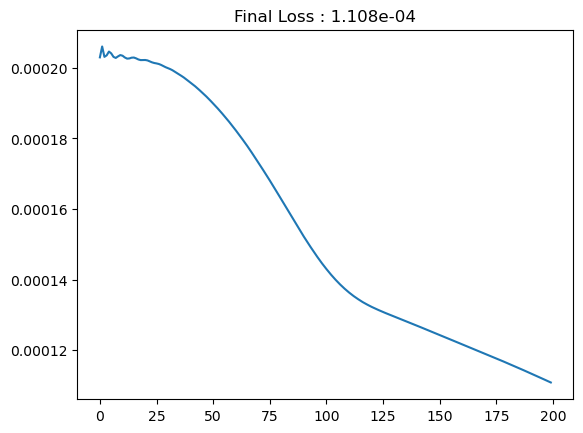

In [548]:
plt.title(f'Final Loss : {loss_vals[-1].item():.3e}')
plt.plot(loss_vals)

In [553]:
loss_vals[0] - loss_vals[-1]

Array(9.21881392e-05, dtype=float64)

## Evaluate

In [549]:
prediction_trained = corrected_simulation(learning_state, psj, partial(apply_corrections, params=params, correction_model=cm), n_rollout)

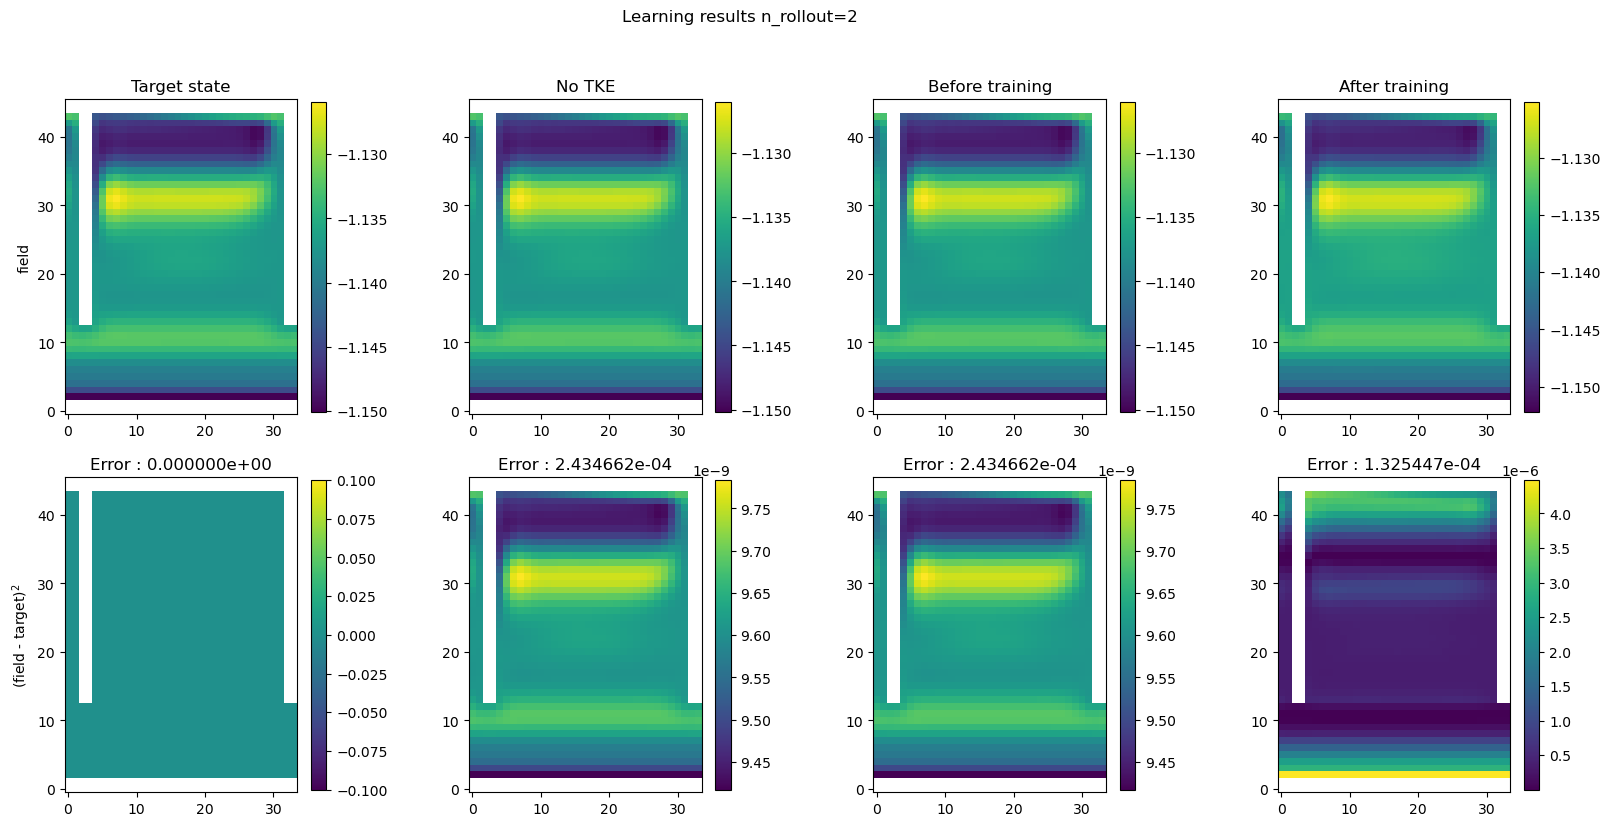

In [559]:
fig, axs = plt.subplots(2,4, figsize=(20,9))
fig.suptitle(f'Learning results {n_rollout=}')
modalities = {'Target state' : target_state, 
              'No TKE' : predicted_notke, 
              'Before training' : prediction_init,
              'After training' : prediction_trained}
target = get_current_variable(target_state, 'temp').at[mask].set(jnp.nan)

axs[0,0].set_ylabel('field')
axs[1,0].set_ylabel(r'(field - target)$^2$')

for a, (name, st) in zip(axs.T, modalities.items()):
    a[0].set_title(name)

    var = get_current_variable(st, 'temp').at[mask].set(jnp.nan)

    # top row: field
    im_state = a[0].imshow(var[..., 0].T)
    fig.colorbar(im_state, ax=a[0], fraction=0.046, pad=0.04)

    # bottom row: squared error vs target
    err = (var - target) ** 2
    im_err = a[1].imshow(err[..., 0].T)
    a[1].set_title(f'Error : {jnp.nanmean(err):2e}')
    fig.colorbar(im_err, ax=a[1], fraction=0.046, pad=0.04)